# Chapter 5 Coastal Engineering: Tidal Analysis

1. [Introduction: Tidal Analysis](#1.-Introduction)
2. [Simulation: NOAA Harmonic Analysis](#2.-Simulation)
3. [Simulation: Tidal Map View](#3.-Simulation)
4. [Simulation: Tidal Analysis](#4.-Simulation)
5. [Self-Assessment](#5.-Self-Assessment)

## 1. Introduction


```{figure} TidalWavePrediction.png
:alt: Descriptive alt text for accessibility
:width: 600px
:name: Tidal Wave Analysis

**Figure 5.7 **: Tidal wave Analysis.

```

### Tidal Harmonic Analysis and Model Fitting

### Overview

This analysis uses observed water level data from the **NOAA Tides & Currents API** to fit a **harmonic tidal model**. The model captures the dominant tidal constituents and estimates a smooth tidal signal. It also evaluates the **goodness of fit** using the **coefficient of determination** $( R^2 $).

---

### Data Source

- **Station**: New Canal Station, New Orleans, LA (ID: 8764227)  
- **Time Period**: January 1–30, 2024  
- **Datum**: Mean Lower Low Water (MLLW)  
- **Units**: Metric  
- **Interval**: Hourly  

Data is retrieved using NOAA’s official API and parsed into a pandas DataFrame.

---

### Harmonic Tidal Model

The model includes two primary tidal constituents:

- **M2**: Principal lunar semidiurnal (period ≈ 12.42 hours)
- **K1**: Lunar diurnal (period ≈ 23.93 hours)

### 🔹 Model Equation

$$
H(t) = a_0 + a_1 \sin(2\pi f_1 t + p_1) + a_2 \sin(2\pi f_2 t + p_2)
$$

Where:
- $( a_0 $): Mean water level  
- $( a_1, a_2 $): Amplitudes of M2 and K1 constituents  
- $( f_1, f_2 $): Frequencies (cycles per hour)  
- $( p_1, p_2 $): Phase shifts (radians)  
- $( t $): Time in hours since start of record

---

### References

{cite}`Pugh1987` offers a scientific foundation for tidal prediction using harmonic analysis, response methods, and tide-surge interactions, emphasizing theoretical rigor and observational techniques. {cite}`USACE2002` USACE (2002) provides engineering-focused guidance, integrating tidal data into coastal design via numerical models like ADCIRC, with emphasis on practical applications and infrastructure planning.


## 2. Simulation

### 🌊 NOAA Tidal Harmonic Analysis — Summary

---

### 🧠 What It Is

This script:
- Fetches **hourly water level data** from NOAA’s New Canal Station in New Orleans
- Fits a **two-constituent harmonic model** (M2 and K1 tides)
- Visualizes observed vs. modeled tide data
- Calculates **goodness of fit (R²)** to assess model accuracy

---

### ⚙️ How It Works

1. **Data Retrieval**:
   - Uses NOAA API with station ID, time range, datum (`MLLW`), and hourly interval
   - Parses CSV response and extracts verified water levels

2. **Time Conversion**:
   - Converts timestamps to hours since initial record

3. **Harmonic Fit**:
   - Models tide as the sum of:
     - M2 (semi-diurnal)
     - K1 (diurnal)
   - Uses `scipy.curve_fit` to optimize parameters

4. **Fit Evaluation**:
   - Computes R² to indicate match quality
   - Adds overlay of predicted tide line in plot

---

### 📊 Inputs

| Variable            | Value                          |
|---------------------|-------------------------------|
| `Station ID`        | 8764227 (New Canal, New Orleans) |
| `Start Date`        | 2024-01-01                    |
| `End Date`          | 2024-01-30                    |
| `Datum`             | MLLW                          |
| `Interval`          | Hourly                        |

---

### 📈 Outputs

- **Plot** showing:
  - Blue curve: observed tide
  - Orange dashed: harmonic fit
- Annotated parameters:
  - Mean level (a₀)
  - M2 and K1 amplitudes and frequencies
  - **R² value** — indicates how well the harmonic model explains observed variations

---

### 🧭 Interpretation

- High R² (near 1) → harmonic model fits observed tides well  
- Differences suggest:
  - Weather-driven anomalies
  - Additional tidal constituents
  - Local hydrodynamic complexity

> _This workflow is useful for validating tidal predictions, calibrating local models, or teaching harmonic tide principles._


🔗 NOAA Water Level Data Link:
https://tidesandcurrents.noaa.gov/waterlevels.html?id=8764227&units=Metric&bdate=20240101&edate=20240130&timezone=GMT&datum=MLLW&interval=h&action=


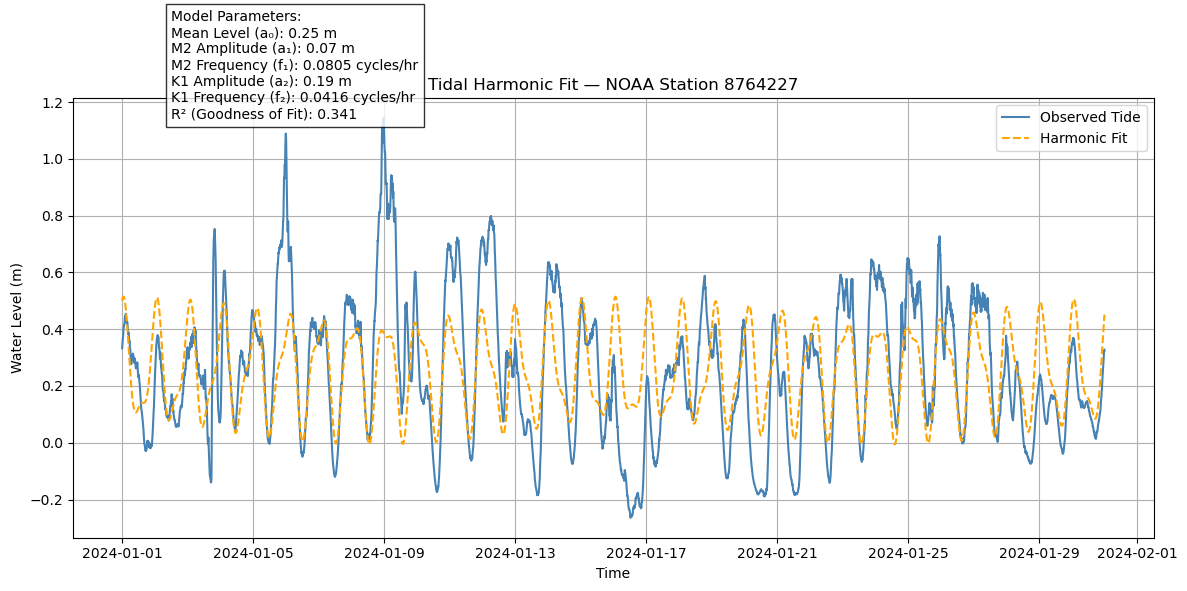

In [13]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from io import StringIO

# 📍 NOAA Station Info
station_id = "8764227"        # New Canal Station, New Orleans LA
start_date = "20240101"
end_date   = "20240130"
datum      = "MLLW"
units      = "Metric"
interval   = "h"
timezone   = "GMT"

# 🌐 NOAA Data Browser Link
data_link = (
    f"https://tidesandcurrents.noaa.gov/waterlevels.html?"
    f"id={station_id}&units={units}&bdate={start_date}"
    f"&edate={end_date}&timezone={timezone}&datum={datum}&interval={interval}&action="
)
print("🔗 NOAA Water Level Data Link:")
print(data_link)

# 🛰️ NOAA API Setup
api_url = "https://api.tidesandcurrents.noaa.gov/api/prod/datagetter"
params = {
    "station": station_id,
    "begin_date": start_date,
    "end_date": end_date,
    "datum": datum,
    "product": "water_level",
    "application": "CopilotTideFit",
    "time_zone": timezone,
    "units": units,
    "format": "csv",
    "interval": interval
}

# 📡 Request Data
response = requests.get(api_url, params=params)

# 🧪 Check for API errors
if "error" in response.text.lower() or "Error" in response.text:
    print("❌ NOAA API returned an error:")
    print(response.text)
    raise ValueError("NOAA API error — check station ID, date range, or parameters.")

# 🧾 Load CSV into DataFrame
df = pd.read_csv(StringIO(response.text))

# 🔍 Identify Water Level Column
possible_cols = [c for c in df.columns if "Water Level" in c or "Observed" in c or "Verified" in c]
level_col = possible_cols[0] if possible_cols else None

if not level_col:
    print("❌ Could not find a valid water level column.")
    print(df.head())
    raise KeyError("Water level column not found in NOAA response.")

# 🕒 Time conversion
df["datetime"] = pd.to_datetime(df["Date Time"])
df["hours"] = (df["datetime"] - df["datetime"].iloc[0]).dt.total_seconds() / 3600
df["level"] = df[level_col]
df = df.dropna(subset=["level"])

# 🎯 Harmonic Model: Two tidal constituents (M2 + K1)
def harmonic_model(t, a0, a1, f1, p1, a2, f2, p2):
    return a0 + a1 * np.sin(2 * np.pi * f1 * t + p1) + a2 * np.sin(2 * np.pi * f2 * t + p2)

# 🔧 Fit model
initial_guess = [0, 0.5, 1/12.42, 0, 0.2, 1/23.93, 0]
params, _ = curve_fit(harmonic_model, df["hours"], df["level"], p0=initial_guess)
df["tidal_fit"] = harmonic_model(df["hours"], *params)

# 📈 Goodness of fit (R²)
residuals = df["level"] - df["tidal_fit"]
ss_res = np.sum(residuals**2)
ss_tot = np.sum((df["level"] - np.mean(df["level"]))**2)
r_squared = 1 - (ss_res / ss_tot)

# 📊 Plotting
plt.figure(figsize=(12, 6))
plt.plot(df["datetime"], df["level"], label="Observed Tide", color="steelblue")
plt.plot(df["datetime"], df["tidal_fit"], label="Harmonic Fit", linestyle="--", color="orange")
plt.xlabel("Time")
plt.ylabel("Water Level (m)")
plt.title(f"Tidal Harmonic Fit — NOAA Station {station_id}")

# 📌 Annotate model parameters
a0, a1, f1, p1, a2, f2, p2 = params
param_text = (
    f"Model Parameters:\n"
    f"Mean Level (a₀): {a0:.2f} m\n"
    f"M2 Amplitude (a₁): {a1:.2f} m\n"
    f"M2 Frequency (f₁): {f1:.4f} cycles/hr\n"
    f"K1 Amplitude (a₂): {a2:.2f} m\n"
    f"K1 Frequency (f₂): {f2:.4f} cycles/hr\n"
    f"R² (Goodness of Fit): {r_squared:.3f}"
)
plt.text(df["datetime"].iloc[int(len(df)/20)], max(df["level"]), param_text,
         fontsize=10, bbox=dict(facecolor='white', alpha=0.8))

plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## 3. Simulation

### 🌊 NOAA Tidal Amplitude Map Viewer — Coastal Station Explorer

---

### 🧠 What It Is

This Jupyter-based tool creates an **interactive geospatial map** of tidal constituent amplitudes (M2 and K1) for selected NOAA stations across the U.S. coastline.

---

### ⚙️ How It Works

1. Defines station metadata: ID, name, latitude, longitude, and amplitudes of two tidal constituents:
   - `M2_amp`: semidiurnal tide amplitude
   - `K1_amp`: diurnal tide amplitude
2. Uses **Cartopy** for geographic plotting
3. Provides a dropdown widget to choose the tidal constituent for display
4. Plots stations as colored markers, scaled by amplitude values

---

### 🎛️ Inputs

| Input               | Description                                  |
|---------------------|----------------------------------------------|
| `Constituent`       | Choose either `"M2_amp"` or `"K1_amp"`       |

---

### 📊 Outputs

- 📍 Map showing station locations across U.S. coastline
- 🌈 Color scale representing selected tidal amplitude (in meters)
- 📌 Station names labeled next to markers
- 🧭 Coastline, state borders, and map extent from West to East Coast

---

### 🧭 How to Interpret

- **Darker markers** → higher tidal amplitude
- Useful for:
  - Understanding regional variation in tidal energy
  - Comparing semidiurnal vs diurnal dominance
  - Site selection for tidal studies or coastal modeling

> _This visualization links geographic context to tidal dynamics—making station-level tidal variation intuitively accessible._


In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import ipywidgets as widgets
from IPython.display import display, clear_output

# 📊 Sample NOAA station data
data = {
    "Station ID": ["8764227", "8771450", "9414290", "8410140", "8443970"],
    "Name": ["New Orleans", "Galveston", "San Francisco", "The Battery, NY", "Boston, MA"],
    "Latitude": [30.03, 29.3, 37.8, 40.7, 42.36],
    "Longitude": [-90.1, -94.8, -122.4, -74.0, -71.05],
    "M2_amp": [0.24, 0.31, 0.65, 1.4, 1.2],  # M2 amplitude in meters
    "K1_amp": [0.08, 0.12, 0.22, 0.3, 0.25]   # K1 amplitude in meters
}
stations = pd.DataFrame(data)

# 🎛️ Interactive plotting function
def plot_tidal_map(constituent):
    clear_output(wait=True)

    fig = plt.figure(figsize=(12, 8))
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.set_extent([-130, -65, 20, 52], crs=ccrs.PlateCarree())
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.BORDERS, linestyle=":")
    ax.add_feature(cfeature.STATES, edgecolor="gray")

    # 🎯 Plot stations colored by selected amplitude
    sc = ax.scatter(
        stations["Longitude"], stations["Latitude"],
        c=stations[constituent], s=100, edgecolor="k", cmap="viridis",
        label=f"{constituent} Amplitude"
    )

    for i, row in stations.iterrows():
        ax.text(row["Longitude"] + 0.5, row["Latitude"], row["Name"], fontsize=9)

    plt.colorbar(sc, label=f"{constituent.replace('_amp', '')} Amplitude (m)", shrink=0.6)
    plt.title(f"U.S. Coastal Stations — {constituent.replace('_amp', '')} Tidal Constituent Amplitude")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# 🎚️ Dropdown for constituent selection
constituent_dropdown = widgets.Dropdown(
    options={"M2 (semidiurnal)": "M2_amp", "K1 (diurnal)": "K1_amp"},
    value="M2_amp",
    description="Constituent:"
)

# 🔄 Display interactive map
interactive_map = widgets.interactive(plot_tidal_map, constituent=constituent_dropdown)
display(interactive_map)

interactive(children=(Dropdown(description='Constituent:', options={'M2 (semidiurnal)': 'M2_amp', 'K1 (diurnal…

## 4. Simulation

### Tidal Harmonic Model Description (Interactive Simulator)

This enhanced tidal model demonstrates how key astronomical constituents contribute to tidal variation over time at coastal locations.

---

### Overview

The model simulates tidal elevation using four dominant harmonic components:
- **M2**: Lunar semidiurnal (≈12.42 hours)
- **S2**: Solar semidiurnal (12 hours)
- **K1**: Lunar-solar diurnal (≈23.93 hours)
- **O1**: Lunar declinational diurnal (≈25.82 hours)

These constituents represent the most influential cycles in global tide patterns. Combining them creates a realistic synthetic tide signal.

---

### Interactive Features

Built with `ipywidgets`, this simulator allows users to:
- Dynamically adjust each constituent's amplitude
- Instantly see changes in the 7-day tidal curve
- Explore how tidal patterns evolve with changing forces

Sliders for:
- `M2_amp`: Semidiurnal lunar force (default = 0.4 m)
- `S2_amp`: Semidiurnal solar force (default = 0.2 m)
- `K1_amp`: Diurnal lunar-solar force (default = 0.2 m)
- `O1_amp`: Diurnal lunar declination (default = 0.1 m)

---

### Mathematical Model

The tidal height $( H(t) $) at time \( t \) (in hours) is given by:

$$
H(t) = a_0 +
       a_1 \sin(2\pi f_1 t) +
       a_2 \sin(2\pi f_2 t) +
       a_3 \sin(2\pi f_3 t) +
       a_4 \sin(2\pi f_4 t)
$$

Where:
- $( a_0 $): Mean sea level (set to 0 in simulation)
- $( a_1, a_2, a_3, a_4 $): Amplitudes for M2, S2, K1, O1 respectively
- $( f_1, f_2, f_3, f_4 $): Frequencies (cycles per hour) for each constituent

---

### Visualization

The plot shows:
- Tidal elevation over a simulated 7-day period
- How interacting cycles create realistic peaks, troughs, and asymmetry
- Effects of adjusting lunar vs. solar forces in real time

The x-axis represents time, and the y-axis shows synthetic water level in meters.

---

### Why Use This Model?

This tool is ideal for:
- Educators teaching tidal dynamics
- Coastal engineers exploring wave-tide interaction
- Students studying harmonic analysis of ocean systems
- Anyone curious about how the Moon and Sun shape Earth’s tides

It provides an intuitive interface and mathematically grounded framework for exploring tides without requiring raw observational data.

---

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from ipywidgets import FloatSlider, interact
import matplotlib.dates as mdates

# Time setup: simulate 7 days with hourly resolution
hours = np.arange(0, 7 * 24 + 1)
start = datetime(2024, 1, 1)
time_stamps = [start + timedelta(hours=int(h)) for h in hours]

# Tidal constituent frequencies (cycles per hour)
frequencies = {
    'M2': 1 / 12.42,
    'S2': 1 / 12.00,
    'K1': 1 / 23.93,
    'O1': 1 / 25.82
}

# Tidal model with multiple constituents
def multi_tide_model(hours, M2_amp, S2_amp, K1_amp, O1_amp):
    tide = (
        M2_amp * np.sin(2 * np.pi * frequencies['M2'] * hours) +
        S2_amp * np.sin(2 * np.pi * frequencies['S2'] * hours) +
        K1_amp * np.sin(2 * np.pi * frequencies['K1'] * hours) +
        O1_amp * np.sin(2 * np.pi * frequencies['O1'] * hours)
    )
    return tide

# Plotting function
def plot_tide(M2_amp, S2_amp, K1_amp, O1_amp):
    tide = multi_tide_model(hours, M2_amp, S2_amp, K1_amp, O1_amp)
    fig, ax = plt.subplots(figsize=(12, 4))
    ax.plot(time_stamps, tide, color='royalblue')
    ax.set_title("Enhanced Tidal Model — M2, S2, K1, O1")
    ax.set_xlabel("Time")
    ax.set_ylabel("Water Level (m)")
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
    ax.grid(True)
    plt.tight_layout()
    plt.show()

# Interactive sliders
interact(plot_tide,
         M2_amp=FloatSlider(value=0.4, min=0.0, max=1.0, step=0.01, description='M2 Amp'),
         S2_amp=FloatSlider(value=0.2, min=0.0, max=1.0, step=0.01, description='S2 Amp'),
         K1_amp=FloatSlider(value=0.2, min=0.0, max=1.0, step=0.01, description='K1 Amp'),
         O1_amp=FloatSlider(value=0.1, min=0.0, max=1.0, step=0.01, description='O1 Amp'));


interactive(children=(FloatSlider(value=0.4, description='M2 Amp', max=1.0, step=0.01), FloatSlider(value=0.2,…

## 5. Self-Assessment

### Quiz: Tidal Harmonic Analysis and Model Fitting

Test your understanding of harmonic tidal modeling using NOAA coastal data.

---

### Conceptual Questions

1. **What is the primary purpose of the harmonic tidal model described in the analysis?**
   - A. To predict weather patterns  
   - ✅ B. To capture dominant tidal constituents and estimate a smooth tidal signal  
   - C. To measure ocean salinity levels  
   - D. To analyze wave heights during storms

2. **Which tidal constituent has a period of approximately 12.42 hours?**
   - A. K1  
   - ✅ B. M2  
   - C. S2  
   - D. O1

3. **What does the coefficient of determination \( R^2 \) indicate in the context of the tidal model?**
   - A. The accuracy of the API data retrieval  
   - ✅ B. The strength of the fit between observed and modeled tidal levels  
   - C. The frequency of tidal constituents  
   - D. The amplitude of tidal waves

4. **What is the role of \( a_0 \) in the harmonic tidal model equation?**
   - A. It represents the amplitude of the tidal constituents  
   - ✅ B. It represents the mean water level  
   - C. It represents the frequency of the tidal constituents  
   - D. It represents the phase shift of the tidal constituents

5. **Which method is used to fit the harmonic tidal model to the observed data?**
   - A. Linear regression  
   - ✅ B. Nonlinear least squares  
   - C. Fourier transform  
   - D. Wavelet analysis


6. **What does the term \( f_1 \) represent in the harmonic tidal model equation?**
   - A. The amplitude of the tidal constituent  
   - ✅ B. The frequency of the tidal constituent  
   - C. The phase shift of the tidal constituent  
   - D. The mean water level

7. **Why are M2 and K1 chosen as the primary tidal constituents in the model?**
   - A. They are the only tidal constituents available in NOAA data  
   - ✅ B. They represent the most significant semidiurnal and diurnal tidal components  
   - C. They have the longest periods among all tidal constituents  
   - D. They are easier to model than other tidal constituents

8. **What is the significance of the phase shift \( p_1 \) in the harmonic tidal model?**
   - A. It determines the amplitude of the tidal constituent  
   - ✅ B. It adjusts the timing of the tidal constituent's peak  
   - C. It represents the frequency of the tidal constituent  
   - D. It sets the baseline water level

9. **What does the term \( t \) represent in the harmonic tidal model equation?**
   - A. The amplitude of the tidal constituent  
   - ✅ B. The time in hours since the start of the record  
   - C. The frequency of the tidal constituent  
   - D. The phase shift of the tidal constituent

10. **What is the primary advantage of using a harmonic tidal model?**
    - A. It eliminates the need for observed data  
    - ✅ B. It provides a smooth and predictive representation of tidal behavior  
    - C. It measures ocean salinity levels  
    - D. It predicts weather patterns

---

### 🌊 Tidal Harmonic Model Description (Interactive Simulator)

This enhanced tidal model demonstrates how key astronomical constituents contribute to tidal variation over time at coastal locations.

---

### 📘 Overview

The model simulates tidal elevation using four dominant harmonic components:
- **M2**: Lunar semidiurnal (≈12.42 hours)
- **S2**: Solar semidiurnal (12 hours)
- **K1**: Lunar-solar diurnal (≈23.93 hours)
- **O1**: Lunar declinational diurnal (≈25.82 hours)

These constituents represent the most influential cycles in global tide patterns. Combining them creates a realistic synthetic tide signal.

---

### 🎛️ Interactive Features

Built with `ipywidgets`, this simulator allows users to:
- Dynamically adjust each constituent's amplitude
- Instantly see changes in the 7-day tidal curve
- Explore how tidal patterns evolve with changing forces

Sliders for:
- `M2_amp`: Semidiurnal lunar force (default = 0.4 m)
- `S2_amp`: Semidiurnal solar force (default = 0.2 m)
- `K1_amp`: Diurnal lunar-solar force (default = 0.2 m)
- `O1_amp`: Diurnal lunar declination (default = 0.1 m)

---

### 📐 Mathematical Model

The tidal height $( H(t) $) at time \( t \) (in hours) is given by:

$$
H(t) = a_0 +
       a_1 \sin(2\pi f_1 t) +
       a_2 \sin(2\pi f_2 t) +
       a_3 \sin(2\pi f_3 t) +
       a_4 \sin(2\pi f_4 t)
$$

Where:
- $( a_0 $): Mean sea level (set to 0 in simulation)
- $( a_1, a_2, a_3, a_4 $): Amplitudes for M2, S2, K1, O1 respectively
- $( f_1, f_2, f_3, f_4 $): Frequencies (cycles per hour) for each constituent

---

### 📈 Visualization

The plot shows:
- Tidal elevation over a simulated 7-day period
- How interacting cycles create realistic peaks, troughs, and asymmetry
- Effects of adjusting lunar vs. solar forces in real time

The x-axis represents time, and the y-axis shows synthetic water level in meters.

---

### 🧪 Why Use This Model?

This tool is ideal for:
- Educators teaching tidal dynamics
- Coastal engineers exploring wave-tide interaction
- Students studying harmonic analysis of ocean systems
- Anyone curious about how the Moon and Sun shape Earth’s tides

It provides an intuitive interface and mathematically grounded framework for exploring tides without requiring raw observational data.

---

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from ipywidgets import FloatSlider, interact
import matplotlib.dates as mdates

# Time setup: simulate 7 days with hourly resolution
hours = np.arange(0, 7 * 24 + 1)
start = datetime(2024, 1, 1)
time_stamps = [start + timedelta(hours=int(h)) for h in hours]

# Tidal constituent frequencies (cycles per hour)
frequencies = {
    'M2': 1 / 12.42,
    'S2': 1 / 12.00,
    'K1': 1 / 23.93,
    'O1': 1 / 25.82
}

# Tidal model with multiple constituents
def multi_tide_model(hours, M2_amp, S2_amp, K1_amp, O1_amp):
    tide = (
        M2_amp * np.sin(2 * np.pi * frequencies['M2'] * hours) +
        S2_amp * np.sin(2 * np.pi * frequencies['S2'] * hours) +
        K1_amp * np.sin(2 * np.pi * frequencies['K1'] * hours) +
        O1_amp * np.sin(2 * np.pi * frequencies['O1'] * hours)
    )
    return tide

# Plotting function
def plot_tide(M2_amp, S2_amp, K1_amp, O1_amp):
    tide = multi_tide_model(hours, M2_amp, S2_amp, K1_amp, O1_amp)
    fig, ax = plt.subplots(figsize=(12, 4))
    ax.plot(time_stamps, tide, color='royalblue')
    ax.set_title("Enhanced Tidal Model — M2, S2, K1, O1")
    ax.set_xlabel("Time")
    ax.set_ylabel("Water Level (m)")
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
    ax.grid(True)
    plt.tight_layout()
    plt.show()

# Interactive sliders
interact(plot_tide,
         M2_amp=FloatSlider(value=0.4, min=0.0, max=1.0, step=0.01, description='M2 Amp'),
         S2_amp=FloatSlider(value=0.2, min=0.0, max=1.0, step=0.01, description='S2 Amp'),
         K1_amp=FloatSlider(value=0.2, min=0.0, max=1.0, step=0.01, description='K1 Amp'),
         O1_amp=FloatSlider(value=0.1, min=0.0, max=1.0, step=0.01, description='O1 Amp'));


interactive(children=(FloatSlider(value=0.4, description='M2 Amp', max=1.0, step=0.01), FloatSlider(value=0.2,…